# INICIALIZAÇÃO

In [42]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet

from sklearn import metrics
from prophet.plot import add_changepoints_to_plot,plot_cross_validation_metric
from prophet.diagnostics import performance_metrics,cross_validation
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose



import seaborn as sns

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

def wmape(y_true, y_pred):
  return np.abs(y_true-y_pred).sum() / np.abs(y_true).sum()

In [2]:
# Symbol da Ibovespa e o intervalo de tempo
symbol = '^BVSP'
start_date = '2017-01-01'
end_date = '2023-12-31'

# Download do yf
df = yf.download(symbol, start=start_date, end=end_date)
df.index = pd.to_datetime(df.index)  # Certifique-se de que o índice seja do tipo DatetimeIndex
df = df.asfreq('B')  # Defina a frequência como diária (ou ajuste para a frequência apropriada)

df_original = yf.download(symbol, start=start_date, end=end_date)
df_original.index = pd.to_datetime(df_original.index)  # Certifique-se de que o índice seja do tipo DatetimeIndex

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


# MODELANDO DATAFRAME INICIAL PARA AS PREVISÕES

In [3]:
df.reset_index(inplace=True)
df = df[['Date','Close']]
df[['ds','y']] = df[['Date','Close']]
df.drop(columns=['Date','Close'], inplace=True)


In [4]:
m = Prophet()
m.add_country_holidays(country_name='BR')

In [5]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1733 entries, 0 to 1823
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1733 non-null   datetime64[ns]
 1   y       1733 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 40.6 KB


In [6]:
df

,ds,y
0,2017-01-02,59589.0
1,2017-01-03,61814.0
2,2017-01-04,61589.0
3,2017-01-05,62071.0
4,2017-01-06,61665.0
...,...,...
1818,2023-12-21,132182.0
1819,2023-12-22,132753.0
1821,2023-12-26,133533.0
1822,2023-12-27,134194.0


# PROPHET EXEMPLO1

AQUI NÓS VAMOS REALIZAR UM TREINO COM UMA FRAÇÃO ALEATORIA DOS DADOS, ISSO TENDE A SER UM POUCO MAIS EFICAZ QUE A SEPARAÇÃO POR DATA POIS MISTURA DADOS E REGISTROS DE DIVERSAS JANELAS DE TEMPO

In [7]:
train_set = df.sample(frac=0.8, random_state=0)
test_set = df.drop(train_set.index)
print(f'training data size : {train_set.shape}')
print(f'testing data size : {test_set.shape}')

training data size : (1386, 2)
testing data size : (347, 2)


In [8]:
m=Prophet(holidays_prior_scale=0,seasonality_prior_scale=20,changepoint_prior_scale=0.01)
m.fit(train_set)

14:44:59 - cmdstanpy - INFO - Chain [1] start processing
14:44:59 - cmdstanpy - INFO - Chain [1] done processing


e:\conda\env\lamanv\project1\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
e:\conda\env\lamanv\project1\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-01-17,62559.045143,56531.179942,78093.964149,62559.045143,62559.045143,5308.729771,5308.729771,5308.729771,728.401745,728.401745,728.401745,4580.328027,4580.328027,4580.328027,0.0,0.0,0.0,67867.774914
1,2017-02-03,63186.496886,58396.130138,78705.593471,63186.496886,63186.496886,5225.347022,5225.347022,5225.347022,473.152406,473.152406,473.152406,4752.194616,4752.194616,4752.194616,0.0,0.0,0.0,68411.843908
2,2017-02-06,63297.223665,57564.281102,78734.270383,63297.223665,63297.223665,5139.092379,5139.092379,5139.092379,433.847266,433.847266,433.847266,4705.245113,4705.245113,4705.245113,0.0,0.0,0.0,68436.316043
3,2017-02-07,63334.132591,58705.247645,78989.432519,63334.132591,63334.132591,5427.208939,5427.208939,5427.208939,728.401745,728.401745,728.401745,4698.807195,4698.807195,4698.807195,0.0,0.0,0.0,68761.341530
4,2017-02-10,63444.859369,59125.949912,79187.398697,63444.859369,63444.859369,5169.082169,5169.082169,5169.082169,473.152406,473.152406,473.152406,4695.929763,4695.929763,4695.929763,0.0,0.0,0.0,68613.941538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342,2023-11-16,114315.010824,105604.844819,125826.562778,114315.010824,114315.010824,1280.503518,1280.503518,1280.503518,599.940042,599.940042,599.940042,680.563476,680.563476,680.563476,0.0,0.0,0.0,115595.514342
343,2023-11-21,114336.418705,105671.958247,126905.717247,114336.418705,114336.418705,1959.792515,1959.792515,1959.792515,728.401745,728.401745,728.401745,1231.390770,1231.390770,1231.390770,0.0,0.0,0.0,116296.211220
344,2023-12-06,114400.642349,107348.029104,127525.208833,114400.642349,114400.642349,2713.486991,2713.486991,2713.486991,191.503503,191.503503,191.503503,2521.983488,2521.983488,2521.983488,0.0,0.0,0.0,117114.129341
345,2023-12-20,114460.584417,106174.503287,127069.567281,114460.584417,114460.584417,2246.268653,2246.268653,2246.268653,191.503503,191.503503,191.503503,2054.765150,2054.765150,2054.765150,0.0,0.0,0.0,116706.853070


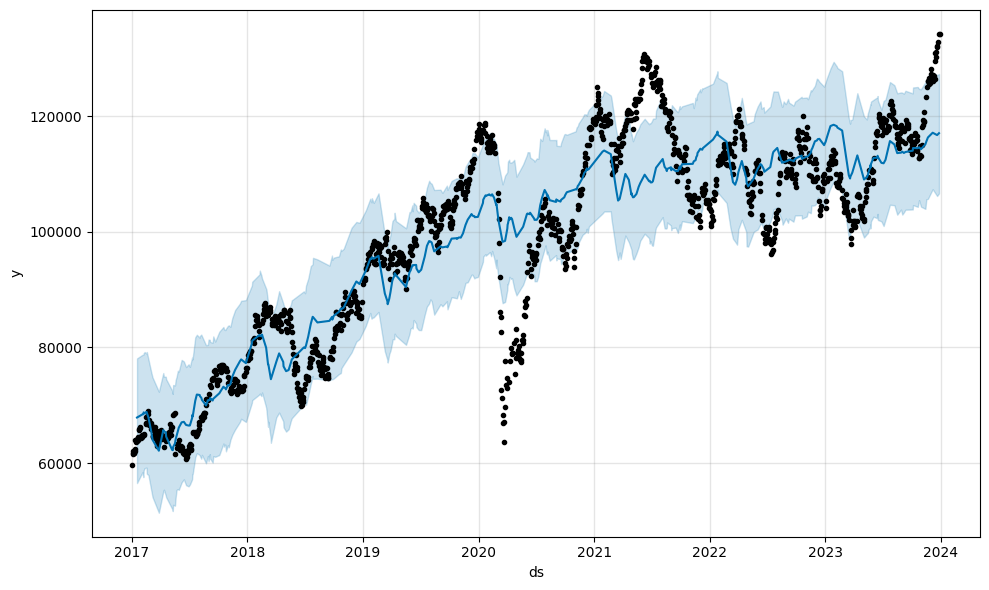

In [9]:
y_pred=m.predict(test_set)
m.plot(y_pred);
y_pred

In [10]:
print('MAE: {}'.format(metrics.mean_absolute_error(test_set['y'].values,y_pred['yhat'].values)))
print('RMSE: {}'.format(metrics.mean_squared_error(test_set['y'].values,y_pred['yhat'].values,squared=False)))

MAE: 6438.335572609635
RMSE: 8412.982052784891


O MAE é uma métrica que representa a média absoluta das diferenças entre as previsões do modelo e os valores reais. No seu caso, o valor do MAE é aproximadamente 4608.51. Isso significa que, em média, as previsões do seu modelo estão distantes dos valores reais por cerca de 4608.51 unidades na mesma escala dos dados originais.

O RMSE é uma métrica que leva em consideração a magnitude dos erros quadráticos. No seu caso, o valor do RMSE é aproximadamente 5966.58. Isso indica que, em média, as previsões do modelo estão distantes dos valores reais por cerca de 5966.58 unidades, penalizando erros maiores de forma mais significativa.

<Axes: xlabel='ds'>

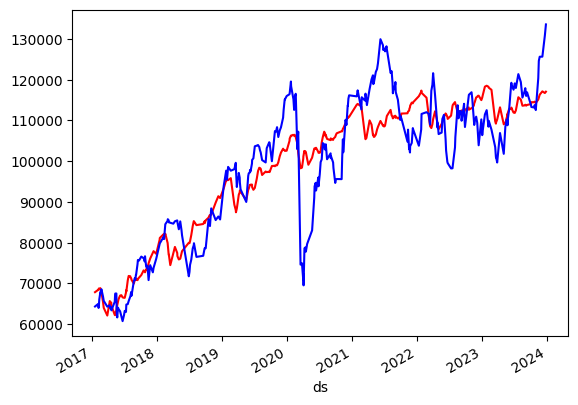

In [11]:
y_pred.set_index('ds')['yhat'].plot(color='red')
test_set.set_index('ds')['y'].plot(color='blue')

e:\conda\env\lamanv\project1\lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
e:\conda\env\lamanv\project1\lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
e:\conda\env\lamanv\project1\lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavi

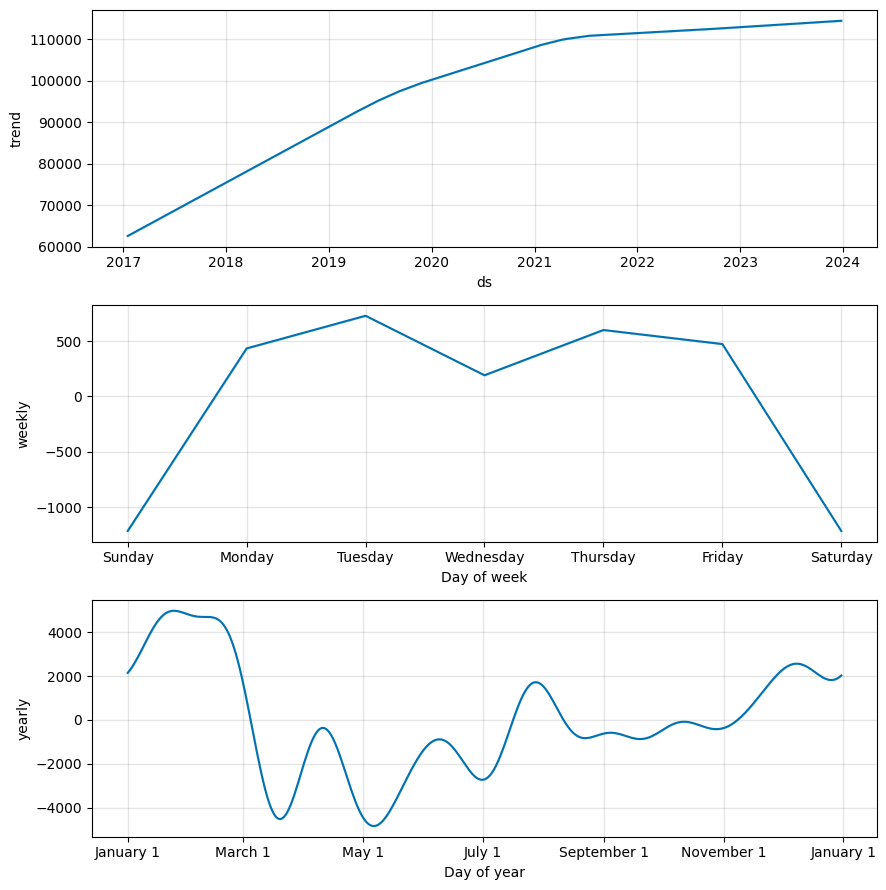

In [12]:
decompos = m.plot_components(y_pred)

In [13]:
df_cv = cross_validation(m,horizon='365 days')
report = performance_metrics(df_cv)
report
report['mape'].mean()

  0%|          | 0/6 [00:00<?, ?it/s]14:45:01 - cmdstanpy - INFO - Chain [1] start processing
14:45:01 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:01,  3.17it/s]14:45:01 - cmdstanpy - INFO - Chain [1] start processing
14:45:01 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:00<00:01,  3.23it/s]14:45:01 - cmdstanpy - INFO - Chain [1] start processing
14:45:01 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:00<00:00,  3.13it/s]14:45:02 - cmdstanpy - INFO - Chain [1] start processing
14:45:02 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:01<00:00,  2.95it/s]14:45:02 - cmdstanpy - INFO - Chain [1] start processing
14:45:02 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:01<00:00,  2.99it/s]14:45:02 - cmdstanpy - INFO - Chain [1] start processing
14:45:03 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 6/6 [00:02<00:00,  2.85it/s]


0.12939707247016152

VALIDAÇÃO CRUZADA COM MAIS DETALHES

In [14]:
df_cv1 = cross_validation(m, initial='730 days', period='180 days', horizon='365 days')
report1 = performance_metrics(df_cv1)
report1
report1['mape'].mean()


  0%|          | 0/9 [00:00<?, ?it/s]14:45:03 - cmdstanpy - INFO - Chain [1] start processing
14:45:03 - cmdstanpy - INFO - Chain [1] done processing
 11%|█         | 1/9 [00:00<00:02,  3.33it/s]14:45:04 - cmdstanpy - INFO - Chain [1] start processing
14:45:04 - cmdstanpy - INFO - Chain [1] done processing
 22%|██▏       | 2/9 [00:00<00:02,  3.24it/s]14:45:04 - cmdstanpy - INFO - Chain [1] start processing
14:45:04 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 3/9 [00:00<00:01,  3.34it/s]14:45:04 - cmdstanpy - INFO - Chain [1] start processing
14:45:04 - cmdstanpy - INFO - Chain [1] done processing
 44%|████▍     | 4/9 [00:01<00:01,  3.42it/s]14:45:04 - cmdstanpy - INFO - Chain [1] start processing
14:45:04 - cmdstanpy - INFO - Chain [1] done processing
 56%|█████▌    | 5/9 [00:01<00:01,  3.47it/s]14:45:05 - cmdstanpy - INFO - Chain [1] start processing
14:45:05 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 6/9 [00:01<00:00,  3.35it/s]14:45:05 - cmds

0.14370102878894686

PREVENDO FUTURO COM MODELO PROPHET

e:\conda\env\lamanv\project1\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
e:\conda\env\lamanv\project1\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


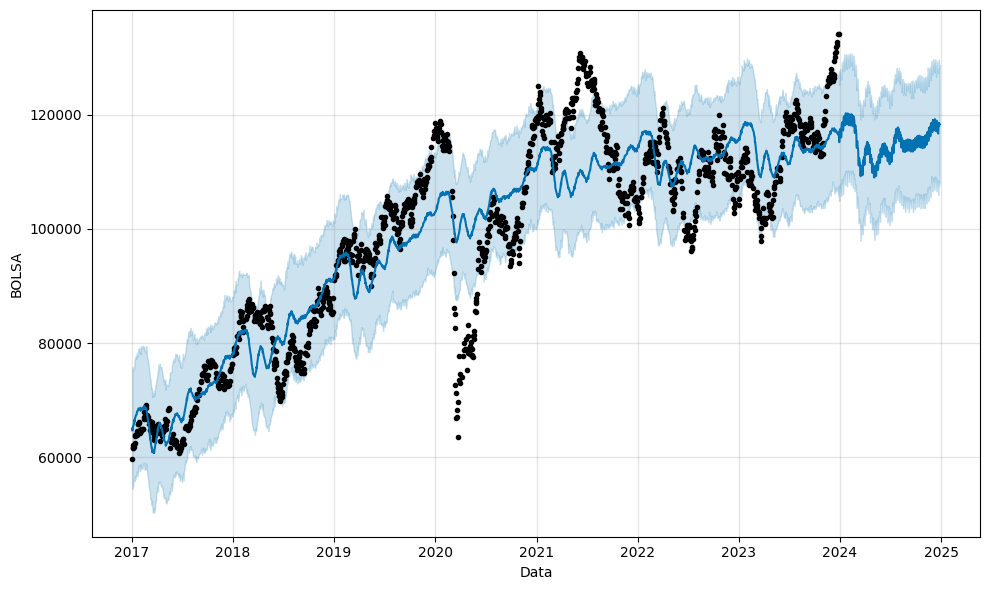

In [15]:
# determinar o período de dias para previsão
future = m.make_future_dataframe(periods=365)

# realizar a previsão para o período estabelecido
forecast = m.predict(future)

m.plot(forecast, xlabel='Data', ylabel='BOLSA');

In [16]:
print('MAE: {}'.format(metrics.mean_absolute_error(test_set['y'].values,y_pred['yhat'].values)))
print('RMSE: {}'.format(metrics.mean_squared_error(test_set['y'].values,y_pred['yhat'].values,squared=False)))

mae = mean_absolute_error(test_set['y'], y_pred['yhat'])
mse = mean_squared_error(test_set['y'], y_pred['yhat'])
rmse = np.sqrt(mse)
wmape1 = wmape(test_set['y'].values, y_pred['yhat'].values)

print("MAE:",mae)
print("MSE:",mse)
print("RMSE:",rmse)
print(f"WMAPE: {wmape1:.2%}")

MAE: 6438.335572609635
RMSE: 8412.982052784891
MAE: 6438.335572609635
MSE: 70778267.02048069
RMSE: 8412.982052784891
WMAPE: 6.56%


# PROPHET EXEMPLO2

Aqui nós vamos separar o dataframe numa janela fixa de tempo e prever o futuro sem a mistura de dados na base de treino e comparar os resultados

In [17]:
# Defina a proporção desejada para a amostragem (por exemplo, 80% para treino)
proporcao_treino = 0.8

# Calcule o índice onde a divisão ocorrerá
indice_divisao = int(len(df) * proporcao_treino)

# Separe o DataFrame continuamente
train_set2 = df.iloc[:indice_divisao]
test_set2 = df.iloc[indice_divisao:]

print(f'training data size : {train_set2.shape}')
print(f'testing data size : {test_set2.shape}')

training data size : (1386, 2)
testing data size : (347, 2)


14:45:07 - cmdstanpy - INFO - Chain [1] start processing
14:45:07 - cmdstanpy - INFO - Chain [1] done processing
e:\conda\env\lamanv\project1\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
e:\conda\env\lamanv\project1\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-08-09,101031.086410,94371.058963,108173.163367,101031.086410,101031.086410,153.979236,153.979236,153.979236,-54.792104,-54.792104,-54.792104,208.771340,208.771340,208.771340,0.0,0.0,0.0,101185.065646
1,2022-08-10,100980.474120,94642.861836,107871.005321,100980.474120,100980.474120,24.928499,24.928499,24.928499,-19.776279,-19.776279,-19.776279,44.704779,44.704779,44.704779,0.0,0.0,0.0,101005.402619
2,2022-08-11,100929.861830,93881.920469,107392.475703,100929.861830,100929.861830,-257.117518,-257.117518,-257.117518,-137.507433,-137.507433,-137.507433,-119.610085,-119.610085,-119.610085,0.0,0.0,0.0,100672.744311
3,2022-08-12,100879.249539,93699.742120,107492.439663,100879.249539,100879.249539,-286.890255,-286.890255,-286.890255,-4.440208,-4.440208,-4.440208,-282.450047,-282.450047,-282.450047,0.0,0.0,0.0,100592.359285
4,2022-08-15,100727.412669,93603.437474,106443.352909,100727.412669,100727.412669,-823.064048,-823.064048,-823.064048,-76.787357,-76.787357,-76.787357,-746.276691,-746.276691,-746.276691,0.0,0.0,0.0,99904.348621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342,2023-12-21,75775.553635,37037.695215,112566.581345,37424.885284,110688.729648,121.844222,121.844222,121.844222,-137.507433,-137.507433,-137.507433,259.351655,259.351655,259.351655,0.0,0.0,0.0,75897.397857
343,2023-12-22,75724.941345,35846.081108,111337.931913,37222.385856,110781.943467,335.696937,335.696937,335.696937,-4.440208,-4.440208,-4.440208,340.137145,340.137145,340.137145,0.0,0.0,0.0,76060.638281
344,2023-12-26,75522.492184,36985.398678,110480.977053,36845.743916,110710.419585,742.347556,742.347556,742.347556,-54.792104,-54.792104,-54.792104,797.139660,797.139660,797.139660,0.0,0.0,0.0,76264.839740
345,2023-12-27,75471.879894,36411.622844,112367.722170,36654.093685,110771.905793,927.366521,927.366521,927.366521,-19.776279,-19.776279,-19.776279,947.142800,947.142800,947.142800,0.0,0.0,0.0,76399.246415


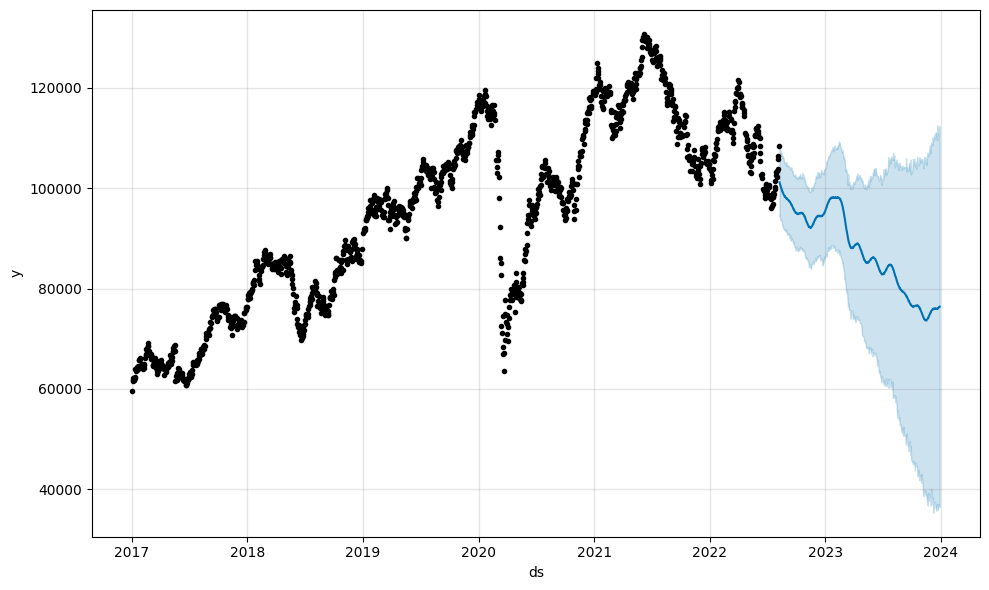

In [18]:
#Instanciando modelo
m2=Prophet()
m2.fit(train_set2)

#Prevendo base test_set
y_pred2=m2.predict(test_set2)
m2.plot(y_pred2);
y_pred2

<Axes: xlabel='ds'>

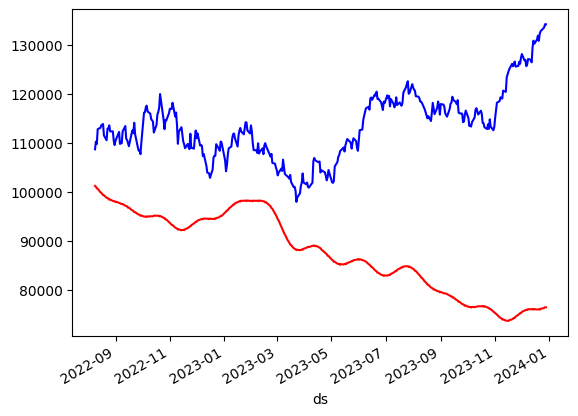

In [19]:
y_pred2.set_index('ds')['yhat'].plot(color='red')
test_set2.set_index('ds')['y'].plot(color='blue')

In [20]:
print('MAE: {}'.format(metrics.mean_absolute_error(test_set2['y'].values,y_pred2['yhat'].values)))
print('RMSE: {}'.format(metrics.mean_squared_error(test_set2['y'].values,y_pred2['yhat'].values,squared=False)))

mae = mean_absolute_error(test_set2['y'], y_pred2['yhat'])
mse = mean_squared_error(test_set2['y'], y_pred2['yhat'])
rmse = np.sqrt(mse)
wmape1 = wmape(test_set2['y'].values, y_pred2['yhat'].values)

print("MAE:",mae)
print("MSE:",mse)
print("RMSE:",rmse)
print(f"WMAPE: {wmape1:.2%}")

MAE: 25798.794655309845
RMSE: 29117.63804904347
MAE: 25798.794655309845
MSE: 847836845.5551041
RMSE: 29117.63804904347
WMAPE: 22.75%


Como esperado, utilizando a separação por data sem randomização dos dados gera um grande impacto negativo na previsão

# ESTACIONARIZAÇÃO DA SÉRIE TEMPORAL

Estacionarizar uma série temporal é um passo importante em análise de séries temporais. Uma série temporal estacionária é aquela em que as propriedades estatísticas, como a média e a variância, permanecem constantes ao longo do tempo. Existem várias razões pelas quais a estacionarização é desejada:

1. **Simplificação da Modelagem:**
   - Modelar séries temporais não estacionárias pode ser mais complexo. Muitos métodos de análise de séries temporais, como modelos ARIMA (AutoRegressive Integrated Moving Average) ou modelos de suavização exponencial, assumem estacionariedade para obter boas previsões.

2. **Compreensão dos Padrões Temporais:**
   - A estacionarização ajuda a revelar padrões temporais mais claros. Tendências e sazonalidades podem obscurecer a verdadeira estrutura subjacente dos dados. Remover esses componentes facilita a identificação de padrões mais relevantes.

3. **Melhoria na Precisão da Previsão:**
   - Muitos modelos de séries temporais assumem que a série é estacionária. Quando você estacionariza uma série temporal, os modelos podem se ajustar melhor aos dados e fazer previsões mais precisas.

4. **Aplicação de Métodos Estatísticos Clássicos:**
   - Métodos estatísticos clássicos, como testes de hipóteses e análises de variância, são frequentemente baseados na premissa de que os dados são estacionários. Ao estacionarizar a série, você torna os métodos estatísticos mais aplicáveis.

5. **Facilitação da Interpretação:**
   - Resultados de análises em séries temporais estacionárias são frequentemente mais fáceis de interpretar. Tendências claras e padrões sazonais tornam-se mais evidentes, facilitando a tomada de decisões informadas.

É importante notar que a estacionarização não é sempre necessária, e há casos em que você pode trabalhar diretamente com séries temporais não estacionárias. No entanto, em muitas situações, tornar a série estacionária facilita a aplicação de técnicas analíticas e melhora a qualidade das previsões.

## ESTACIONARIZAÇÃO COM DIFERENCIAÇÃO

In [21]:
sns.set_style('darkgrid')

In [22]:
df_estac = df

In [23]:
X = df_estac.y.values
result = adfuller(X)

print("Teste ADF")
print(f"Teste Estatístico: {result[0]}")
print(f"P-Value: {result[1]}")
print("Valores críticos:")

for key, value in result[4].items():
  print(f"\t{key}: {value}")

Teste ADF
Teste Estatístico: -1.76608783710626
P-Value: 0.3974233074590711
Valores críticos:
	1%: -3.4341487606638452
	5%: -2.863217940480328
	10%: -2.5676632884862807


Diagnosticada que série não é estacionaria pois o p-value é maior que 0,05

In [24]:
# Aplicar a primeira diferenciação
df_estac['y_diff1'] = df_estac['y'].diff()

# Remover a primeira observação (NaN resultante da primeira diferenciação)
df_estac = df_estac.dropna()

In [25]:
# Aplicar o teste ADF na primeira diferenciação
result_diff1 = adfuller(df_estac['y_diff1'])
print("Teste ADF após a primeira diferenciação:")
print(f"Teste Estatístico: {result_diff1[0]}")
print(f"P-Value: {result_diff1[1]}")
print("Valores críticos:")
for key, value in result[4].items():
  print(f"\t{key}: {value}")
  
if result_diff1[1] < 0.05:
  print("Série estacionária!")
else:
  print("Série não estacionária!")

Teste ADF após a primeira diferenciação:
Teste Estatístico: -13.058853515888844
P-Value: 2.0674808076840813e-24
Valores críticos:
	1%: -3.4341487606638452
	5%: -2.863217940480328
	10%: -2.5676632884862807
Série estacionária!


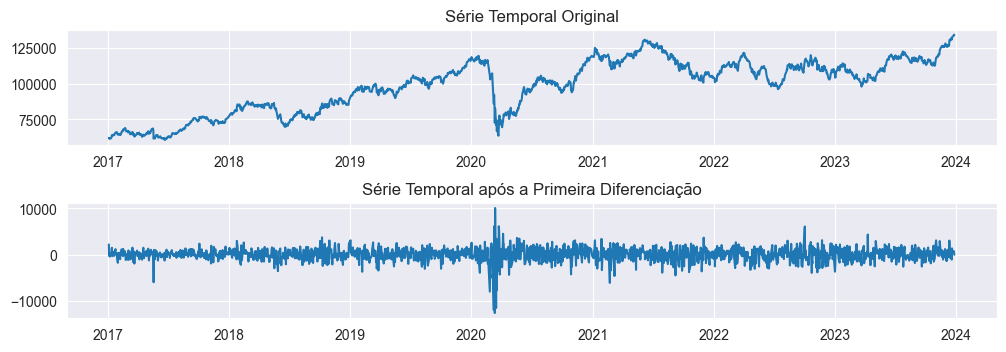

In [26]:
# Plotar a série original
plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(df_estac['ds'], df_estac['y'])
plt.title('Série Temporal Original')

# Plotar a série após a primeira diferenciação
plt.subplot(3, 1, 2)
plt.plot(df_estac['ds'], df_estac['y_diff1'])
plt.title('Série Temporal após a Primeira Diferenciação')

plt.subplots_adjust(hspace=0.5)

In [27]:
# Dropar a coluna 'y'
df_estacfim = df_estac.drop(columns=['y'])

# Renomear 'y_diff1' para 'y'
df_estacfim = df_estacfim.rename(columns={'y_diff1': 'y'})

df_estacfim

,ds,y
1,2017-01-03,2225.0
2,2017-01-04,-225.0
3,2017-01-05,482.0
4,2017-01-06,-406.0
5,2017-01-09,35.0
...,...,...
1818,2023-12-21,1378.0
1819,2023-12-22,571.0
1821,2023-12-26,780.0
1822,2023-12-27,661.0


### PROPHET + ESTACIONARIZAÇÃO

In [28]:
# Defina a proporção desejada para a amostragem (por exemplo, 80% para treino)
proporcao_treino = 0.8

# Calcule o índice onde a divisão ocorrerá
indice_divisao = int(len(df_estacfim) * proporcao_treino)

# Separe o DataFrame continuamente
train_set3 = df_estacfim.iloc[:indice_divisao]
test_set3 = df_estacfim.iloc[indice_divisao:]

print(f'training data size : {train_set3.shape}')
print(f'testing data size : {test_set3.shape}')

training data size : (1385, 2)
testing data size : (347, 2)


14:45:10 - cmdstanpy - INFO - Chain [1] start processing
14:45:10 - cmdstanpy - INFO - Chain [1] done processing
e:\conda\env\lamanv\project1\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
e:\conda\env\lamanv\project1\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-08-09,340.540425,-1761.483217,2088.969434,340.540425,340.540425,-279.128980,-279.128980,-279.128980,-169.419318,-169.419318,-169.419318,-109.709661,-109.709661,-109.709661,0.0,0.0,0.0,61.411446
1,2022-08-10,340.487708,-2106.206312,1829.157223,340.487708,340.487708,-422.839232,-422.839232,-422.839232,-312.810363,-312.810363,-312.810363,-110.028869,-110.028869,-110.028869,0.0,0.0,0.0,-82.351524
2,2022-08-11,340.434991,-2045.025773,1686.899537,340.434991,340.434991,-532.534988,-532.534988,-532.534988,-423.476684,-423.476684,-423.476684,-109.058303,-109.058303,-109.058303,0.0,0.0,0.0,-192.099996
3,2022-08-12,340.382274,-2103.930890,1683.854317,340.382274,340.382274,-507.058933,-507.058933,-507.058933,-400.159425,-400.159425,-400.159425,-106.899508,-106.899508,-106.899508,0.0,0.0,0.0,-166.676659
4,2022-08-15,340.224123,-2143.906723,1693.931254,340.224123,340.224123,-565.118110,-565.118110,-565.118110,-470.643351,-470.643351,-470.643351,-94.474759,-94.474759,-94.474759,0.0,0.0,0.0,-224.893987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342,2023-12-21,314.234589,-1710.103622,1829.464012,314.234048,314.235095,-268.155846,-268.155846,-268.155846,-423.476684,-423.476684,-423.476684,155.320839,155.320839,155.320839,0.0,0.0,0.0,46.078743
343,2023-12-22,314.181872,-1752.588106,1906.779456,314.181328,314.182379,-223.618836,-223.618836,-223.618836,-400.159425,-400.159425,-400.159425,176.540589,176.540589,176.540589,0.0,0.0,0.0,90.563036
344,2023-12-26,313.971004,-1481.670886,2202.040969,313.970456,313.971513,95.926872,95.926872,95.926872,-169.419318,-169.419318,-169.419318,265.346191,265.346191,265.346191,0.0,0.0,0.0,409.897876
345,2023-12-27,313.918287,-1593.320364,2167.454029,313.917735,313.918796,-26.847395,-26.847395,-26.847395,-312.810363,-312.810363,-312.810363,285.962968,285.962968,285.962968,0.0,0.0,0.0,287.070892


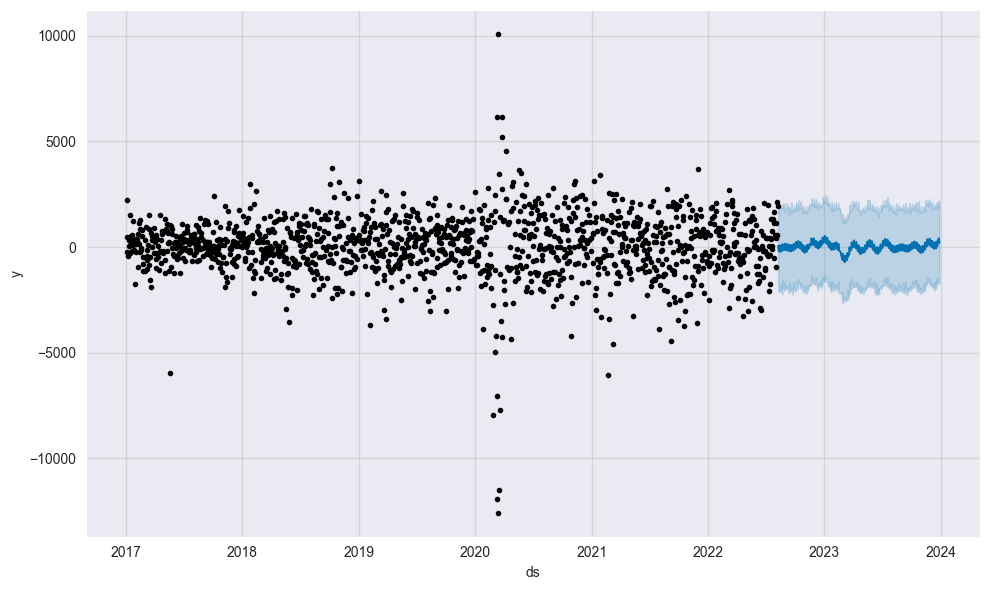

In [29]:
#Instanciando modelo
m3=Prophet()
m3.fit(train_set3)

#Prevendo base test_set
y_pred3=m3.predict(test_set3)
m3.plot(y_pred3);
y_pred3

<Axes: xlabel='ds'>

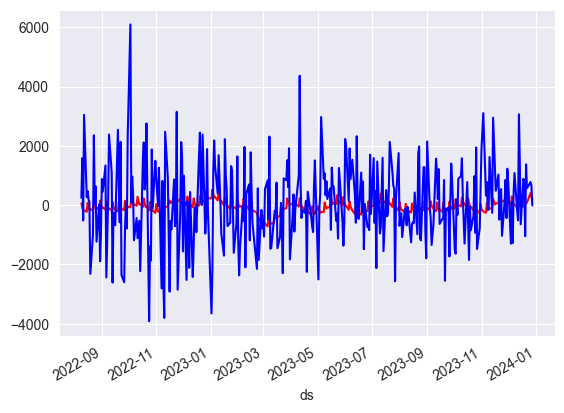

In [30]:
y_pred3.set_index('ds')['yhat'].plot(color='red')
test_set3.set_index('ds')['y'].plot(color='blue')

e:\conda\env\lamanv\project1\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
e:\conda\env\lamanv\project1\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


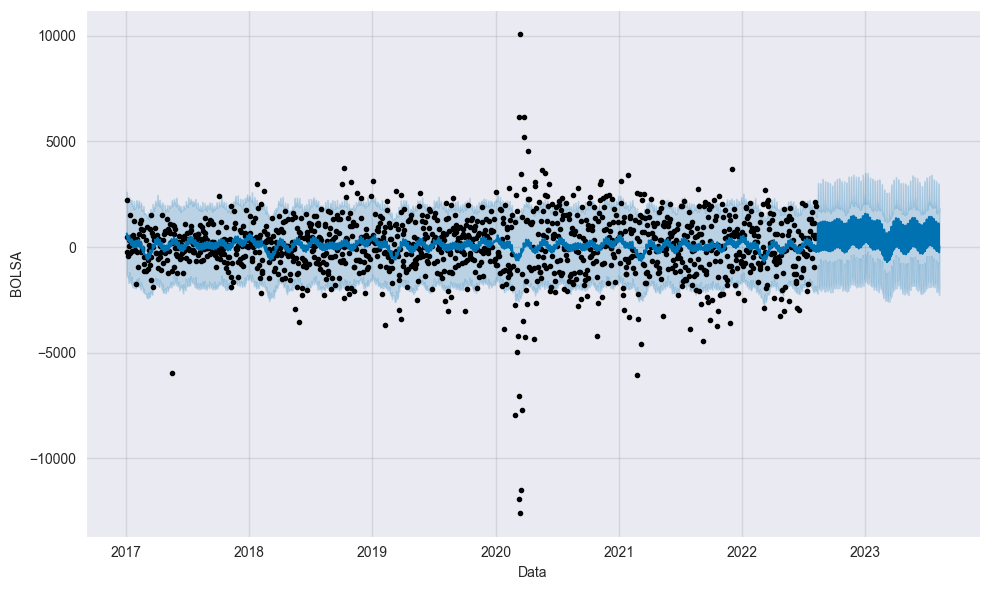

In [31]:
# determinar o período de dias para previsão
future = m3.make_future_dataframe(periods=365)

# realizar a previsão para o período estabelecido
forecast = m3.predict(future)

m3.plot(forecast, xlabel='Data', ylabel='BOLSA');

In [32]:
mae = mean_absolute_error(test_set3['y'], y_pred3['yhat'])
mse = mean_squared_error(test_set3['y'], y_pred3['yhat'])
rmse = np.sqrt(mse)
wmape1 = wmape(test_set3['y'].values, y_pred3['yhat'].values)

print("MAE:",mae)
print("MSE:",mse)
print("RMSE:",rmse)
print(f"WMAPE: {wmape1:.2%}")

MAE: 1074.7045405595711
MSE: 1907596.2210311743
RMSE: 1381.1575656061746
WMAPE: 99.55%


## ESTACIONARIZAÇÃO LOGARITMICA

In [33]:
sns.set_style('darkgrid')
df_estaclog = df

In [34]:
X = df_estaclog.y.values
result = adfuller(X)

print("Teste ADF")
print(f"Teste Estatístico: {result[0]}")
print(f"P-Value: {result[1]}")
print("Valores críticos:")

for key, value in result[4].items():
  print(f"\t{key}: {value}")

Teste ADF
Teste Estatístico: -1.76608783710626
P-Value: 0.3974233074590711
Valores críticos:
	1%: -3.4341487606638452
	5%: -2.863217940480328
	10%: -2.5676632884862807


Diagnosticada que série não é estacionaria pois o p-value é maior que 0,05

In [35]:
df_estaclog['y_log'] = np.log(df_estaclog['y'])

In [36]:
# Aplicar o teste ADF na primeira diferenciação
result_diff1 = adfuller(df_estaclog['y_log'])
print("Teste ADF após a logaritmo:")
print(f"Teste Estatístico: {result_diff1[0]}")
print(f"P-Value: {result_diff1[1]}")
print("Valores críticos:")
for key, value in result[4].items():
  print(f"\t{key}: {value}")
  
if result_diff1[1] < 0.05:
  print("Série estacionária!")
else:
  print("Série não estacionária!")

Teste ADF após a logaritmo:
Teste Estatístico: -1.9689932447261065
P-Value: 0.3003317298134821
Valores críticos:
	1%: -3.4341487606638452
	5%: -2.863217940480328
	10%: -2.5676632884862807
Série não estacionária!


## ESTACIONARIZAÇÃO COM SUAVIZAÇÃO EXPONENCIAL

A suavização exponencial é uma técnica que atribui pesos decrescentes exponencialmente aos valores anteriores. Pode ser útil para remover padrões sazonais.

In [37]:
sns.set_style('darkgrid')
df_estacexp = df

In [38]:
X = df_estacexp.y.values
result = adfuller(X)

print("Teste ADF")
print(f"Teste Estatístico: {result[0]}")
print(f"P-Value: {result[1]}")
print("Valores críticos:")

for key, value in result[4].items():
  print(f"\t{key}: {value}")

Teste ADF
Teste Estatístico: -1.76608783710626
P-Value: 0.3974233074590711
Valores críticos:
	1%: -3.4341487606638452
	5%: -2.863217940480328
	10%: -2.5676632884862807


Diagnosticada que série não é estacionaria pois o p-value é maior que 0,05

In [39]:
model = ExponentialSmoothing(df_estacexp['y'])
result = model.fit()
df_estacexp['y_smoothed'] = result.fittedvalues

e:\conda\env\lamanv\project1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [40]:
# Aplicar o teste ADF na primeira diferenciação
result_diff1 = adfuller(df_estacexp['y_smoothed'])
print("Teste ADF após suavização exponencial:")
print(f"Teste Estatístico: {result_diff1[0]}")
print(f"P-Value: {result_diff1[1]}")
  
if result_diff1[1] < 0.05:
  print("Série estacionária!")
else:
  print("Série não estacionária!")

Teste ADF após suavização exponencial:
Teste Estatístico: -1.7830268959577236
P-Value: 0.3889203299768505
Série não estacionária!


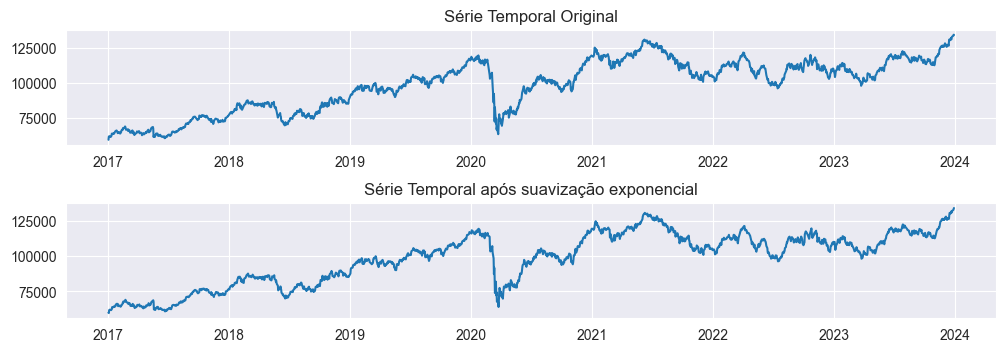

In [41]:
# Plotar a série original
plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(df_estacexp['ds'], df_estacexp['y'])
plt.title('Série Temporal Original')

# Plotar a série após a primeira diferenciação
plt.subplot(3, 1, 2)
plt.plot(df_estacexp['ds'], df_estacexp['y_smoothed'])
plt.title('Série Temporal após suavização exponencial')

plt.subplots_adjust(hspace=0.5)

## ESTACIONARIZAÇÃO COM DECOMPOSIÇÃO DA SÉRIE TEMPORAL

A decomposição da série temporal envolve decompor a série em componentes como tendência, sazonalidade e resíduos. O pacote statsmodels em Python fornece uma função para isso.

In [43]:
sns.set_style('darkgrid')
df_estacdecomp = df
df_estacdecomp = df_estacdecomp[['ds', 'y']]

In [57]:
df_estacdecomp = df_estacdecomp.asfreq('B')  # Defina a frequência como diária (ou ajuste para a frequência apropriada)



In [60]:
# Sort the DataFrame by the 'ds' column to make sure dates are in ascending order
df_estacdecomp.sort_values(by='ds', inplace=True)

# Fill NaN values in 'y' column with the average of the closest dates
df_estacdecomp['y'] = df_estacdecomp['y'].fillna(df_estacdecomp['y'].interpolate())

In [61]:
result = seasonal_decompose(df_estacdecomp['y'], model='additive')
df_estacdecomp['trend'] = result.trend
df_estacdecomp['seasonal'] = result.seasonal
df_estacdecomp['residual'] = result.resid

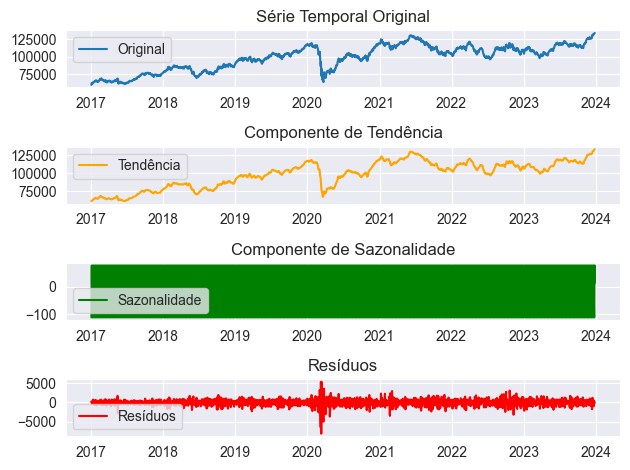

In [62]:
# Subplot 1: Série Temporal Original
plt.subplot(4, 1, 1)
plt.plot(df_estacdecomp['y'], label='Original')
plt.legend()
plt.title('Série Temporal Original')

# Subplot 2: Tendência
plt.subplot(4, 1, 2)
plt.plot(df_estacdecomp['trend'], label='Tendência', color='orange')
plt.legend()
plt.title('Componente de Tendência')

# Subplot 3: Sazonalidade
plt.subplot(4, 1, 3)
plt.plot(df_estacdecomp['seasonal'], label='Sazonalidade', color='green')
plt.legend()
plt.title('Componente de Sazonalidade')

# Subplot 4: Resíduos
plt.subplot(4, 1, 4)
plt.plot(df_estacdecomp['residual'], label='Resíduos', color='red')
plt.legend()
plt.title('Resíduos')

plt.tight_layout()
plt.show()